# Document Setup

- Project ID: EMB_ex19
- Researchers: DK
- Current Version: v1.0

See associated protocol for more details.

In [1]:
# Stdlib
import sys
import os
import random
from datetime import datetime
from IPython.display import display, Latex

# Scientific computing
import numpy as np
from sklearn.linear_model import LogisticRegression

# Network science
import networkx as nx
from node2vec import Node2Vec as N2V

# Data handling and vis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.lines import Line2D

# Project source
sys.path.append("../../src/")
import synthetic
import utils

# Miscellaneous
from tqdm.auto import tqdm

In [2]:
metadata = {
    "PROJECT_ID": "EMB_ex19",
    "RESEARCHERS": "DK",
    "CURRENT_VERSION": "v1.0",
    "DATE": datetime.today().strftime("%Y%m%d")
}
TAG = "{PROJECT_ID}{CURRENT_VERSION}_{RESEARCHERS}_{DATE}".format(**metadata)

# Experiment

## Preface

**Goal**

Utilize logistic regression to reconstruct multiplexes from embedded remnants.

**Procedure**

1. [Set-up] Let $G, H$ be the layers of a duplex.
2. [Set-up] Aggregate $G, H$; call it $A$.
3. [Set-up] Observe some partial observations from $A$; call them $\theta_G, \theta_H$.
4. [Set-up] Calculate the remnants; $R_G = A - \theta_H, R_H = A - \theta_G$.
5. [Embedding] Embed $R_G, R_H$; call them $E_G, E_H$.
6. [Reconstruction] Select some edge, $e = (i,j) \in A$.
7. [Reconstruction] Calculate $d_G(e) = d_{E_G}(i, j), d_H(e) = d_{E_H}(i, j)$ and the quotient $d(e) = \frac{d_G(e)}{d_H(e)}$.
8. [Reconstruction] Train a logistic regression model with $\{ d(e)\}$ as predictor.
9. [Reconstruction] Predict originating layer for each edge in the test set, $A - \theta_G - \theta_H$.
10. [Analysis] Analyze reconstructive performance.

**Notes**
The core of the reconstruction from embedded layers is training a logistic model
$\begin{equation}\begin{aligned}
    R(e) &= \frac{1}{1 + e^{-\beta_1(d_G(e) / d_H(e)) - \beta_0}}\\
    &= \frac{1}{1 + e^{-\beta_0}e^{-\beta_1(d_G(e) / d_H(e))}}\\
    &= \frac{1}{1 + e^{-\beta_0}e^{-\beta_1d(e)}}\\
\end{aligned}\end{equation}$

where $d(e)$ is the quotient of $d_G(e), d_H(e)$ where $d_G(e) = d_G(i,j) = \| E_G[i] - E_G[j] \|$ for edge $e = (i,j)$ and likewise for $d_H(e)$.



## Prerequisite code

In [3]:
def get_representation(G, params):
    """
    Embed a monoplex with node2vec. Wrapper from @Minsuk Kim.
    """
    # Unpack parameters
    dimensions, walk_length, num_walks, workers,\
    window, min_count, batch_words = params

    # Create node2vec model
    n2v = N2V(G,
        dimensions = dimensions,
        walk_length = walk_length,
        num_walks = num_walks,
        workers = workers,
        quiet = True,
    )

    # Embed topology under specified n2v model
    embedding = n2v.fit(window = window,
        min_count = min_count,
        batch_words = batch_words,
    )

    # Format resultant vectors
    # ! NOTE: Currently broken for real networks
    # ! >>> Broken >>>
    # * Output format: Array with row [i] corresponding to embedded vector of node i
    # representation = np.array([
    #     embedding.wv['%d' % i]
    #     for i in range(G.number_of_nodes())
    # ])
    # ! <<< Broken <<<

    # ! >>> Hot fix >>>
    embedding = embedding.wv
    index_ = embedding.index_to_key
    vectors_ = embedding.vectors
    representation = {int(index_[idx]): vectors_[idx] for idx in range(G.number_of_nodes())}
    # ! <<< Hot fix <<<

    return representation

In [4]:
def calculate_distances(edge, E_G, E_H):
    # Retrieve nodes incident to edge
    i, j = edge

    # Calculate distance between incident nodes in both embeddings
    d_G = np.linalg.norm(E_G[i] - E_G[j])
    d_H = np.linalg.norm(E_H[i] - E_H[j])

    return d_G, d_H

In [5]:
def calculate_distance_ratio(edge, E_G, E_H):
    d_G, d_H = calculate_distances(edge, E_G, E_H)
    if d_H == 0 or d_G == 0:
        return 1
    else:
        return d_G / d_H

## Workflow

In [6]:
# * Experiment Parameters
# >>> Node2Vec embedding <<<
dimensions = 128  # euclidean dimension to embedd
walk_length = 30  # number of nodes in each walk
num_walks = 100  # number of walks per node
workers = 10  # for cpu parallel work
window = 10  # maximum distance between the current and predicted word within a sentence.
min_count = 1  # ignores all words with total frequency lower than this
batch_words = 4  # [unsure]
params = [dimensions, walk_length, num_walks, workers, window, min_count, batch_words]

# >>> Logistic regression <<<
penalty = "l2"  # L2 regularization

# >>> Other <<<
repeat = 100  # number of simulations

In [7]:
# * Steps (1) - Get desired duplex
D = utils.read_file("../../data/input/raw/duplex_system=celegans.edgelist")
G, H = utils.duplex_network(D, 1, 2)

### Single run (dev)

In [8]:
# * Steps (2) thru (4) - Observe a priori information and calculate remnants
theta = 0.8
R_G, R_H, testset, trainset = utils.partial_information(G, H, theta)

In [9]:
# * Step (5) - Embed remnants
E_G = get_representation(R_G, params)
E_H = get_representation(R_H, params)

In [10]:
# * Steps (6) and (7) - Calculate distances of nodes incident to edges in both embeddings
distance_ratios_train = np.array([
    calculate_distance_ratio(edge, E_G, E_H)
    for edge in trainset
]).reshape(-1, 1)
distance_ratios_test = np.array([
    calculate_distance_ratio(edge, E_G, E_H)
    for edge in testset
]).reshape(-1, 1)

labels_train = list(trainset.values())
labels_test = list(testset.values())

Text(0.5, 1.0, 'Test set distances')

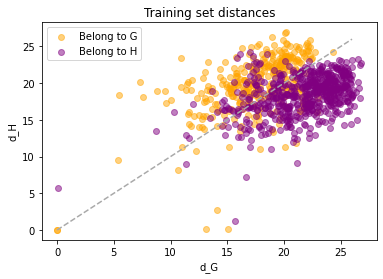

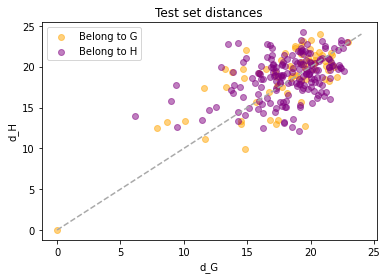

In [11]:
plt.figure()

pts0 = [calculate_distances(edge, E_G, E_H) for edge, class_ in trainset.items() if class_ == 0]
pts1 = [calculate_distances(edge, E_G, E_H) for edge, class_ in trainset.items() if class_ == 1]
plt.scatter([pt[0] for pt in pts1], [pt[1] for pt in pts1], label="Belong to G", color="orange", alpha=0.5)
plt.scatter([pt[0] for pt in pts0], [pt[1] for pt in pts0], label="Belong to H", color="purple", alpha=0.5)

xmax = max(max([p[0] for p in pts0]), max([p[1] for p in pts0]))
xrange = np.arange(0, xmax)
plt.plot(xrange, xrange, linestyle="--", color="darkgray")


plt.legend()

plt.xlabel("d_G")
plt.ylabel("d_H")
plt.title("Training set distances")

# -----

plt.figure()

pts0 = [calculate_distances(edge, E_G, E_H) for edge, class_ in testset.items() if class_ == 0]
pts1 = [calculate_distances(edge, E_G, E_H) for edge, class_ in testset.items() if class_ == 1]
plt.scatter([pt[0] for pt in pts1], [pt[1] for pt in pts1], label="Belong to G", color="orange", alpha=0.5)
plt.scatter([pt[0] for pt in pts0], [pt[1] for pt in pts0], label="Belong to H", color="purple", alpha=0.5)

xmax = max(max([p[0] for p in pts0]), max([p[1] for p in pts0]))
xrange = np.arange(0, xmax)
plt.plot(xrange, xrange, linestyle="--", color="darkgray")

plt.legend()

plt.xlabel("d_G")
plt.ylabel("d_H")
plt.title("Test set distances")

Text(0.5, 1.0, 'Layer origination as a function of distance quotient')

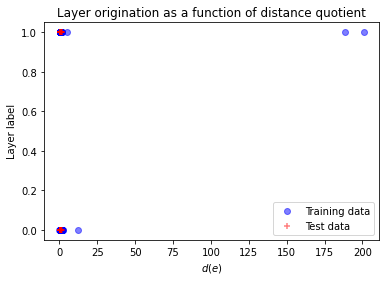

In [12]:
plt.figure()

plt.scatter(distance_ratios_train, labels_train, label="Training data", color="blue", marker="o", alpha=0.5)
plt.scatter(distance_ratios_test, labels_test, label="Test data", color="red", marker="+", alpha=0.5)

plt.legend()

plt.xlabel("$d(e)$")
plt.ylabel("Layer label")
plt.title("Layer origination as a function of distance quotient")

In [13]:
# * Step (8) - Train a logistic regression
model = LogisticRegression(random_state=37)
model.fit(distance_ratios_train, labels_train)

coef = model.coef_
intercept = model.intercept_

Text(0.5, 1.0, 'Layer origination as a function of distance quotient')

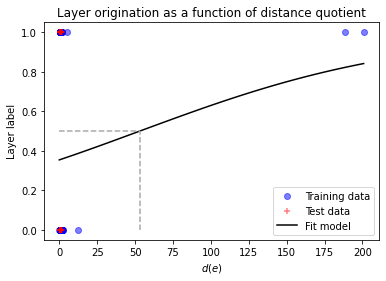

In [14]:
plt.figure()

expit = lambda x: 1 / (1 + np.exp(-x*coef[0] - intercept[0]))
xmin = min(min(distance_ratios_train), min(distance_ratios_test))
xmax = max(max(distance_ratios_train), max(distance_ratios_test))
xrange = np.linspace(xmin, xmax)

plt.scatter(distance_ratios_train, labels_train, label="Training data", color="blue", marker="o", alpha=0.5)
plt.scatter(distance_ratios_test, labels_test, label="Test data", color="red", marker="+", alpha=0.5)

plt.plot(xrange, [expit(x) for x in xrange], label="Fit model", color="black")

model_inv_threshold = -intercept[0]/coef[0]
plt.vlines(model_inv_threshold, 0, 0.5, linestyle="--", color="darkgray")
plt.hlines(0.5, xmin, model_inv_threshold, linestyle="--", color="darkgray")

plt.legend()

plt.xlabel("$d(e)$")
plt.ylabel("Layer label")
plt.title("Layer origination as a function of distance quotient")

In [15]:
# * Step (9) - Predict testset with reconstruction
print(f"Model score: {model.score(distance_ratios_test, labels_test):.4f}")

Model score: 0.7115


In [16]:
model.score(distance_ratios_train, labels_train)

0.6440860215053763

### Full experiment

In [ ]:
def workflow(G, H, theta):
    # * Steps (2) thru (4) - Observe a priori information and calculate remnants
    R_G, R_H, testset, trainset = utils.partial_information(G, H, theta)

    # * Step (5) - Embed remnants
    E_G = get_representation(R_G, params)
    E_H = get_representation(R_H, params)

    # * Steps (6) and (7) - Calculate distances of nodes incident to edges in both embeddings
    distance_ratios_train = np.array([
        calculate_distance_ratio(edge, E_G, E_H)
        for edge in trainset
    ]).reshape(-1, 1)
    distance_ratios_test = np.array([
        calculate_distance_ratio(edge, E_G, E_H)
        for edge in testset
    ]).reshape(-1, 1)

    labels_train = list(trainset.values())
    labels_test = list(testset.values())

    # * Step (8) - Train a logistic regression
    model = LogisticRegression(random_state=37)
    model.fit(distance_ratios_train, labels_train)

    coef = model.coef_
    intercept = model.intercept_

    # * Step (9) - Predict testset with reconstruction
    score = model.score(distance_ratios_test, labels_test)

## Analysis

### Processing and cleanup

### Visualizations